# Feature-based registration - Compute and match SIFT

In [1]:
import os
import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt

from imp import reload

import sys
sys.path.append(os.path.join('..', '..'))
from toolbox import transform
reload(transform)

<module 'toolbox.transform' from '/Users/williammarstrand/privat/DTU/Kandidat/1. Semester/Advanced Image Analysis/02506-advanced-image-analysis/exercises/week4/../../toolbox/transform.py'>

In [2]:
img1 = cv2.imread(os.path.join('data', 'CT_lab_high_res.png'), cv2.IMREAD_GRAYSCALE)

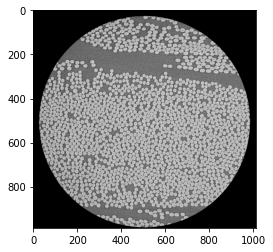

In [3]:
plt.imshow(img1, cmap='gray')

In [4]:
# transformation matrix for translation
M = np.float32([[1, 0, 50],
                [0, 1, 50],
                [0, 0, 1]])
scale_percent = 60 # percent of original size
width = int(img1.shape[1] * scale_percent / 100)
height = int(img1.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
translated = cv2.warpPerspective(resized, M, (img1.shape[0], img1.shape[1]))
img2 = cv2.rotate(translated, cv2.cv2.ROTATE_90_CLOCKWISE)

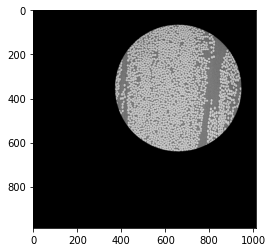

In [5]:
plt.imshow(img2, cmap='gray')

### Detect SIFT

In [6]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

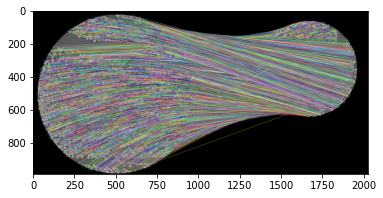

(<matplotlib.image.AxesImage at 0x7f83099219a0>, None)

In [7]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    # Apply the Lowe criterion best should be closer than second best
    if m.distance/(n.distance + 10e-10) < 0.6:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()


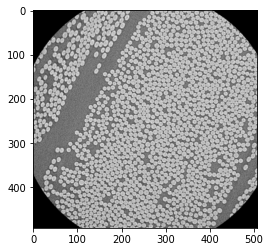

In [8]:
#%% Create a test image - Rotate, scale and crop image

ang = 67
sc = 0.6
imr = scipy.ndimage.rotate(scipy.ndimage.zoom(img1,sc),ang,reshape=False)[50:-50,50:-50]
plt.imshow(imr, cmap='gray')

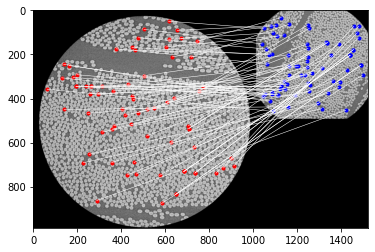

In [9]:
#%% Plot the keypoints with very low threshold (0.1) to see what is going on
pts_im1, pts_im2 = transform.match_SIFT(img1, imr, 0.1)
transform.plot_matching_keypoints(img1,imr,pts_im1, pts_im2)

In [10]:
s,R,t = transform.get_transformation(pts_im1, pts_im2)

Transformations: Rotation:
[[ 0.39071637  0.92051096]
 [-0.92051107  0.39071633]]

Translation:
[[-137.46911274]
 [ 410.04541108]]

Scale: 0.5997478365898132

Angle: 67.0009183782613


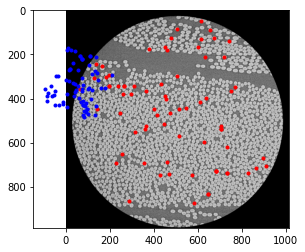

In [11]:
print(f'Transformations: Rotation:\n{R}\n\nTranslation:\n{t}\n\nScale: {s}\n\nAngle: {np.arccos(R[0,0])/np.pi*180}')
pts_im1_1 = s*R@pts_im2 + t

fig,ax = plt.subplots(1)
ax.imshow(img1, cmap='gray')
ax.plot(pts_im1[0],pts_im1[1],'.r')
ax.plot(pts_im1_1[0],pts_im1_1[1],'.b')